In [1]:
# What we aim to do here is numerically simulate a package of gfp molecule signal linked to a stochastically-
# varying promoter state in a gene. The idea is that if we tweak our parameters in our numerical model, we 
# can then fit the numerical model to our actual fly embryo data, in order to be able to say something about
# how this gene is turned on.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import gfp_signal
from telegraph import exponential

In [4]:
# Simulate a transcription promoter using my exponentially-distributed wait time telegraph signal and
# my simulation of GFP agglomeration following an "ON" or "OFF" prompt

# make the system more likely to linger in off stage: choose k_off to be less than k_on such that
#                       mean_off = 1.0 / k_off   >    1.0 / k_on
k_on = 0.08
k_off = 0.03  
duration = 555 # seconds
stepsize = 3   # seconds / step

tel = exponential(k_on, k_off, duration, stepsize)

promoter_sig = tel.signal

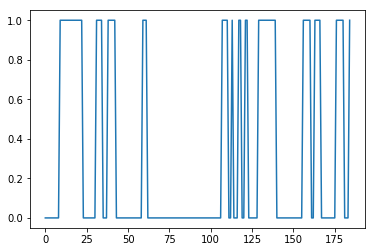

In [5]:
plt.plot(promoter_sig)

In [6]:
# Now add the numerically-simulated agglomeration of GFP stem-loops which generate the fluorescence signal we see
# parameters
sig = promoter_sig
k_gfp = 3       # gfp molecules / second
cts = 1000      # counts per gfp molecule
k_polII = 1     # how many polII's started per second
max_loops = 24  # max number of gfp loops that attach to each polII site

gfp = gfp_signal.gfp_signal(telegraph=sig, k_gfp=k_gfp, k_polII=k_polII, cts_per_gfp=cts, max_loops=max_loops, stepsize=3)

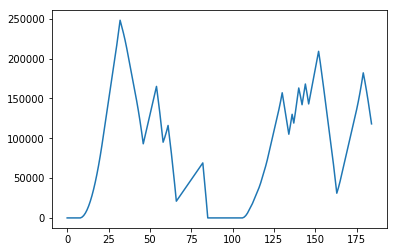

In [7]:
plt.plot(gfp.counts)

In [8]:
# Now let's simulate this ~80 times to simulate what we get from actual data.
# Parameters:
k_on = 0.02
k_off = 0.05  
duration = 575 # seconds
stepsize = 3   # seconds / step

k_gfp = 3       # gfp molecules / second
cts = 1000      # counts per gfp molecule
k_polII = 1     # how many polII's started per second
max_loops = 24  # max number of gfp loops that attach to each polII site


num = 80               # number of traces in our simulated dataset
auto_traces = []       # empty list of autocorrelation arrays
traces = []            # empty list of traces 

for i in range(num):
    tel = exponential(k_on, k_off, duration, stepsize)  # create a new signal every time      
    gfp = gfp_signal.gfp_signal(telegraph=tel.signal, k_gfp=k_gfp, k_polII=k_polII, cts_per_gfp=cts, max_loops=max_loops, stepsize=3)
    traces.append(gfp.norm)
    
    auto_trace = np.correlate(gfp.norm, gfp.norm, 'same')
    auto_traces.append(auto_trace / np.max(auto_trace))

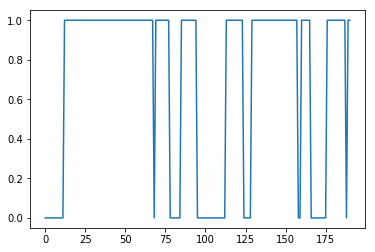

In [9]:
plt.plot(tel.signal)

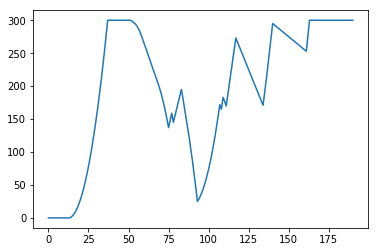

In [10]:
plt.plot(traces[2])
plt.show()

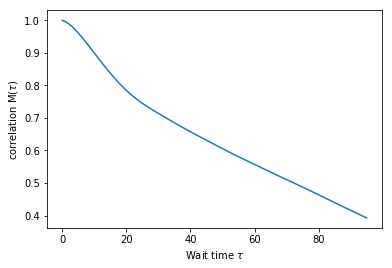

In [11]:
# Now compute the average correlation function from the set of 70.
# We see that the autocorrelation function appears as a decay curve
mean_auto_data = np.mean(auto_traces, axis = 0)
plt.plot((mean_auto_data[np.argmax(mean_auto_data):]))   # plot only half of the autocorrelation function (symmetric on both sides of max)


t = np.linspace(start=0,stop=100 )

plt.xlabel(r'Wait time $\tau$')
plt.ylabel(r'correlation M($\tau$)')
plt.show()

In [12]:
# create a routine that bootstraps a set of data arrays according to Coulon & Lardon (2016)

cutoff = np.argmax(mean_auto_data)    # take only the right half of autocorrelation fns, based on our og dataset's max
traces = np.asarray(traces)           # convert to a numpy array to play with indices
n_traces = len(traces)                # number of traces in our dataset
n_trials = 1000                      # how many times we wish to compute the bootstrap loop
trace_indx = np.arange(n_traces)      # the index range of the list of traces
auto_averages = []                    # list of averaged autocorrelation functions (should be n_trials long)


# sample randomly, with replacement, a new set of n_traces 10,000 times
for i in range(n_trials):
    
    # from our list of traces, sample radomly the trace_index of these datum in the list
    random_indx = np.random.choice(trace_indx, size=n_traces, replace=True)  
    
    # then use this array of indices to create our random package of traces
    sample_set = traces[random_indx]
    auto_list = []
    
    # next compute the autocorrelation function from this package of traces
    for sample in sample_set:
        aut = np.correlate(sample, sample, 'same')
        auto_list.append(aut / np.max(aut))   # normalize each correlation for easy fitting later
    
    auto_mu = np.mean(auto_list, axis=0)      # now average together the autocorrelation functions from the list    
    auto_averages.append(auto_mu[cutoff:])    # add the right half of the average to the list of average autocorrelation functions


In [13]:
auto_averages = np.asarray(auto_averages)

In [14]:
# now let's compute the standard deviations of the set of 10000 autocorrelation functions. This is the STANDARD ERROR
# on our dataset
# compute at each time step (tau):
std_dev_arr = np.std(auto_averages, axis=0)

In [15]:
len(std_dev_arr)

96

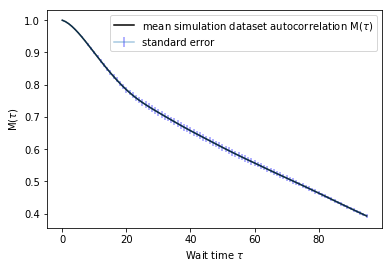

In [16]:
tau = np.arange(len(mean_auto_data[cutoff:]))   # tau array to plot against

plt.errorbar(x=tau, y=mean_auto_data[cutoff:], yerr=(std_dev_arr, std_dev_arr), ecolor='b', alpha=0.4, label = 'standard error')  

# show the mean of our original dataset in red
plt.plot(tau, mean_auto_data[cutoff:], color='k', label = r'mean simulation dataset autocorrelation M($\tau$)')
plt.legend()
plt.xlabel(r'Wait time $\tau$')
plt.ylabel(r'M($\tau$)')
plt.show()

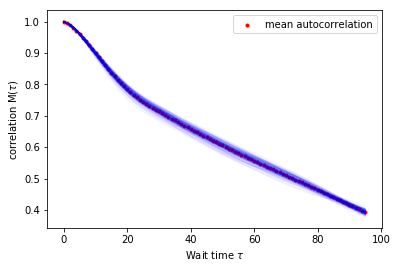

In [17]:
for i in auto_averages[::10]:
    plt.plot(i, color='b', alpha=0.05)   # plot a bunch of our traces to see error zones
    
plt.scatter(tau, mean_auto_data[cutoff:], marker='.', color='r', label = 'mean autocorrelation')   # show the mean of our original dataset in red
plt.legend()
plt.xlabel(r'Wait time $\tau$')
plt.ylabel(r'correlation M($\tau$)')
plt.show()

In [18]:
def decay_model(x, a):
    return np.exp(-x*a)

In [19]:
from scipy.optimize import curve_fit

popt,pcov = curve_fit(decay_model, tau, mean_auto_data[cutoff:])


In [20]:
popt

array([0.00999347])

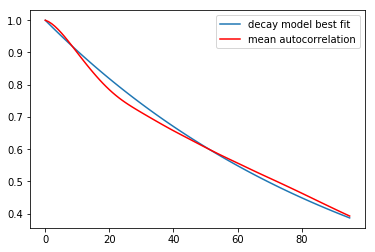

In [21]:
#plt.plot(tau, mean_auto_data[cutoff:])
plt.plot(tau, decay_model(tau, popt[0]), label='decay model best fit')
plt.plot(mean_auto_data[cutoff:], color='r', label = 'mean autocorrelation')   # show the mean of our original dataset in red
plt.legend()
plt.show()